In [3]:
import os 
import torch
import torchvision
from torchvision import transforms,datasets
import numpy as np
from PIL import Image
from matplotlib.pyplot import imshow
from torch import nn,optim
!pip install torchmetrics
import torchmetrics
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset
from scipy.spatial import distance as dist
from sklearn.metrics import roc_auc_score,roc_curve,auc
from matplotlib import pyplot as plt

  Using cached torchmetrics-0.6.0-py3-none-any.whl (329 kB)


In [4]:
# Импорт и подготовка разметки для открытых глаз  
from xml.etree import ElementTree
open_train_tree = ElementTree.parse(r'/content/drive/MyDrive/Eyes_test_case/Train_open.xml')
open_train_root = open_train_tree.getroot()
open_train_targets = []
for i in np.arange(127,1,-1):
  open_train_point = open_train_root[i][0].attrib['points'].replace(';', ',').split(',')
  open_train_point.append(open_train_root[i].attrib['name'])
  open_train_targets.append(open_train_point)


In [2]:
# Импорт и подготовка разметки для закрытых глаз  
from xml.etree import ElementTree
close_train_tree = ElementTree.parse(r'/content/drive/MyDrive/Eyes_test_case/Train_closed.xml')
close_train_root = close_train_tree.getroot()
close_train_targets = []
for i in np.arange(127,1,-1):
  close_train_point = close_train_root[i][0].attrib['points'].replace(';', ',').split(',')
  close_train_point.append(close_train_root[i].attrib['name'])
  close_train_targets.append(close_train_point)

In [5]:
# Инициализация регрессора 6 пар координат - (x,y)  
class Eye_CNN(nn.Module):
    def __init__(self):
        super(Eye_CNN, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),             #24x24
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding= 0),                #22x22
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=0),                #20x20
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),   #10x10
            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding= 0),              #8x8
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),   #4x4
            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),          #4x4
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),          #4x4
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
           )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4*4*512, 1024),
            nn.Dropout(p=0.5, inplace=False),
            nn.ReLU(),
            nn.Linear(1024, 128),
            nn.Dropout(p=0.5, inplace=False),
            nn.ReLU(),
            nn.Linear(128, 12),
        )

    def forward(self, x):
        x = self.feature(x)
        coordinates = self.classifier(x)
        return coordinates

In [6]:
# Используем GPU, если имеется  
if torch.cuda.is_available():
 device = torch.device("cuda")
else:
 device = torch.device("cpu")
model = Eye_CNN().to(device)

In [7]:
# Приведение изображения в вид доступный для нейронной сети  
transform = transforms.Compose([
 transforms.Grayscale(),
 transforms.ToTensor(),
 transforms.Normalize(mean = [131.70], std =  [50.24]),
 transforms.ConvertImageDtype(torch.float)
 ])

In [8]:
"""Preparing own dataset.

Keyword arguments:
root -- Путь к размеченным изображениям 
annotations -- Объект с разметкой
transform -- Паттерн преобразования

"""
class Eye_dataset(Dataset):
  def __init__(self, root, annotations, transform = None):
    self.annotations = annotations
    self.root = root
    self.transform = transform

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self,index):
    img_path = os.path.join(self.root,self.annotations[index][12])
    image = Image.open(img_path)
    target = torch.tensor(list(map(float,self.annotations[index][0:12])))

    if self.transform:
      image = self.transform(image)
    return (image,target)

In [9]:
# Инициализация обучающего Dataloader'a  
train_data_path = "/content/drive/MyDrive/Eyes_test_case/Points_clf/Train/"
train_data = Eye_dataset(root=train_data_path, annotations = open_train_targets + close_train_targets, transform=transform)
batch_size = 16
train_data_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size,shuffle=True)

In [10]:
# Задаем стратегию обновления весов и функцию потерь  
loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
# Метрики подсчета качества  
MSE = torchmetrics.MeanSquaredError()
Test_acc = torchmetrics.Accuracy()

In [11]:
# Подключаем Tensorboard, чтобы интерактивно наблюдать за обучением модели
writer = SummaryWriter()
load_ext tensorboard
% tensorboard --logdir=/content/runs --port=6005

SyntaxError: ignored

In [ ]:
# Обучение модели  
epoch_MSE = []
for epoch in range(2000):
  for batch in train_data_loader:
    inputs, target = batch
    inputs.unsqueeze(0)
    optimizer.zero_grad()
    inputs = inputs.to(device)
    target = target.to(device)
    output = model(inputs)
    target = target.to('cpu')
    output = output.to('cpu')
    mse = float(MSE(output, target))
    epoch_MSE.append(mse)
    loss = loss_fn(output, target)
    loss.backward()
    optimizer.step()
  epoch_mse = np.array(epoch_MSE).mean()
  print(f"MSE on epoch : {epoch_mse}")
  writer.add_scalar('Epoch_MSE/train',epoch_mse)
mse = MSE.compute()
print(f"MSE on all data: {mse}")

In [12]:
# Когда модель обучена и веса сохранены, для её тестирования импортируем их из файла
model.load_state_dict(torch.load('/content/drive/MyDrive/Eyes_test_case/weights.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

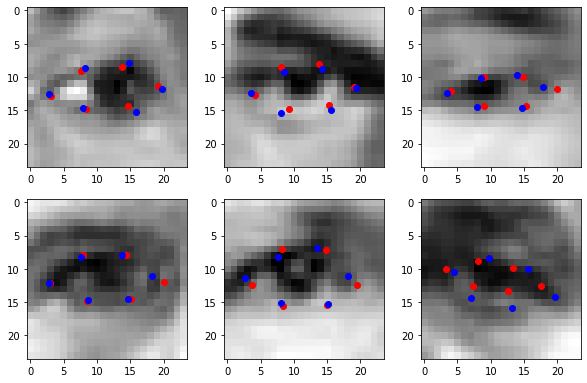

In [27]:
# Визуальная проверка качества регрессии на открытых глазах
with torch.no_grad():
  plt.figure(figsize=(10, 10))
  for i in range(6):
    z = train_data.__getitem__(i)
    points = list(map(float,z[1][:12]))
    x = model(z[0].unsqueeze(0).to(device))
    y = x.to('cpu').detach().numpy()[0]
    plt.subplot(3, 3, i+1)
    plt.imshow(z[0].squeeze(), cmap='gray')
    plt.plot(y[::2],y[1::2],'ro')
    plt.plot(points[::2],points[1::2],'bo')

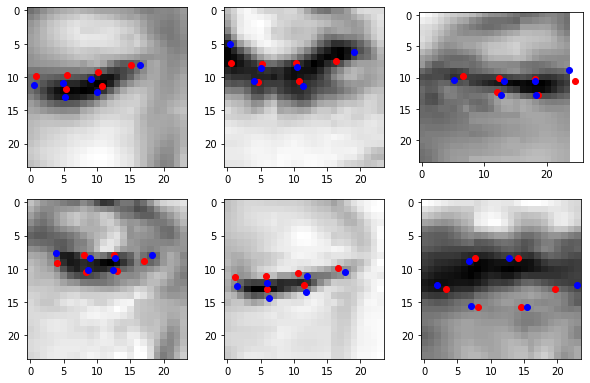

In [28]:
# Визуальная проверка качества регрессии на закрытых глазах
with torch.no_grad():
  plt.figure(figsize=(10, 10))
  for i in range(6):
    z = train_data.__getitem__(126+i)
    points = list(map(float,z[1][:12]))
    x = model(z[0].unsqueeze(0).to(device))
    y = x.to('cpu').detach().numpy()[0]
    plt.subplot(3, 3, i+1)
    plt.imshow(z[0].squeeze(), cmap='gray')
    plt.plot(y[::2],y[1::2],'ro')
    plt.plot(points[::2],points[1::2],'bo')

In [13]:
""" Расчет метрики EAR - eye_aspect_ratio(eye: list[list]) -> float """
def eye_aspect_ratio(eye):
  A = dist.euclidean(eye[1], eye[5])  # Вычисляем расстояние между центральными точками задающими положение глаз
  B = dist.euclidean(eye[2], eye[4])

  C = dist.euclidean(eye[0], eye[3])  # Расстояние между крайними точками
  ear = (A + B) / (2.0 * (C+0.0000001)) # Eye_Aspect_ratio
  return ear

In [14]:
""" Получаем метку класса по координатам точек глаза - Threshold_separation(outputs: np.array ) -> Boolean """
def Threshold_separation(outputs): 
  if eye_aspect_ratio(list(zip(outputs[::2],outputs[1::2]))) < 0.24:  # Отсекаем по значения по порогу 0.24, те что больше открытые, меньше закрытые
    return 0
  else:
    return 1

In [15]:
# Инициализация тестового Dataloader'a 
test_data_path = "/content/drive/MyDrive/Eyes_test_case/Points_clf/Test/"
test_data = datasets.ImageFolder(root=test_data_path, transform=transform)
batch_size = 16
test_data_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=batch_size)

In [15]:
#Считаем точность модели на тестовой выборке
with torch.no_grad():
  for batch in test_data_loader:
    inputs, target = batch
    inputs.unsqueeze(0)
    inputs = inputs.to(device)
    target = target.to(device)
    output = model(inputs)
    target = target.to('cpu')
    output = output.to('cpu')
    output = output.detach().numpy()
    labels = np.array(list(map(Threshold_separation,output)))
    test_acc = Test_acc(torch.from_numpy(labels), target)
    test_mse = float(MSE(torch.from_numpy(labels), target))
    print(f"Accuracy on batch: {test_acc}")
    #writer.add_scalar('Epoch_MSE/test',epoch_acc)
    #writer.add_scalar('Epoch_MSE/test',test_mse)
  test_acc = Test_acc.compute()
  print(f"Accuracy on all data: {test_acc}")

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Accuracy on batch: 1.0
Accuracy on batch: 0.875
Accuracy on batch: 1.0
Accuracy on batch: 1.0
Accuracy on batch: 0.875
Accuracy on batch: 0.9375
Accuracy on batch: 1.0
Accuracy on batch: 0.9375
Accuracy on batch: 1.0
Accuracy on all data: 0.9580419659614563


In [22]:
#Сохранение весов модели
torch.save(model.state_dict(), '/content/drive/MyDrive/Eyes_test_case/weights.pt')

In [16]:
"""  Здесь я заметил, что задача поставлена не совсем такая, необходимо из дистанций
получить уверенности, а не метки и по уверенностям считаем нужные метрики

"""
# Задаем функцию преобраования из произвольного вещественного, в ограниченное 0 и 1
import numpy as np
def sigmoid(x):
  return 1/(1+np.exp(-350*(x-0.24)))

In [17]:
# По точкам считаем расстояние и выводим из сигмоиды уверенность
def points_to_conf(outputs):
  return sigmoid(eye_aspect_ratio(list(zip(outputs[::2],outputs[1::2]))))

In [18]:
#Cчитаем AUC
conf = []
tar = []
with torch.no_grad():
  for batch in test_data_loader:
    inputs, target = batch
    inputs.unsqueeze(0)
    inputs = inputs.to(device)
    target = target.to(device)
    output = model(inputs)
    target = target.to('cpu')
    output = output.to('cpu')
    output = output.detach().numpy()
    for i in np.array(list(map(points_to_conf,output))):
      conf.append(i)
    for j in target:
      tar.append(target[j])
test_auc = roc_auc_score(tar,conf)
print(test_auc)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


0.9498015873015873


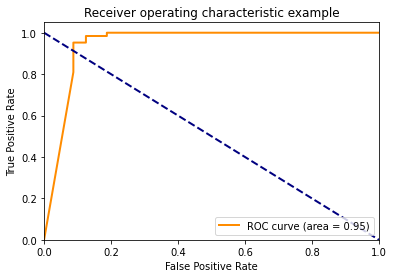

In [30]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [1, 0], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [19]:
#Считаем FalsePositiveRate,TruePositiveRate и FalseNegativeRate
fpr, tpr, _ = roc_curve(tar,conf)
roc_auc = auc(fpr, tpr)
fnr = list(map(lambda x : 1 - x, tpr))
arg = np.argmin(np.absolute(fnr - fpr))  # Индекс при, котором разница TPR и FNR минимальна

In [24]:
"""EER - точка, в которой линии FNR и FPR пересекаются. Однако т.к значения массивов FNR и FPR  дискретны,
    то мы принимаем EER равным одному из значений в точке где разница минимальна
"""
EER = fnr[arg]
print(EER)

0.06349206349206349
